# A Real-world Example

Let's look at an example in the context of our actual data.

## Constant Writer Responses

How many reports have been sent constant writer notifications?

### Setup and Code

In [165]:
%load_ext sql
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


First we'll set up a quick reporting table with flags as to whether we've printed/sent the constant writer template

In [171]:
%%sql
DROP TABLE IF EXISTS cw_responses;
CREATE TEMP TABLE cw_responses AS 
SELECT 
  r.id,
  r.assigned_section,
  CASE WHEN a.description = 'Printed ''CRT - Constant Writer'' template' THEN true ELSE false END AS printed_cw,
  CASE WHEN a.verb = 'Contacted complainant:' AND a.description LIKE '%Constant Writer%' THEN true ELSE false END AS sent_cw
FROM cts_forms_report r
LEFT JOIN actstream_action a
ON r.id::TEXT = a.target_object_id

[]

And let's pre-organize that for the bar chart...

In [172]:
def get_counts(*, section='(any)'):
    counts = %sql SELECT \
            SUM(CASE WHEN printed_cw AND sent_cw THEN 1 ELSE 0 END) AS both, \
            SUM(CASE WHEN printed_cw AND NOT sent_cw THEN 1 ELSE 0 END) AS printed_only, \
            SUM(CASE WHEN NOT printed_cw AND sent_cw THEN 1 ELSE 0 END) AS sent_only, \
            SUM(CASE WHEN NOT printed_cw AND NOT sent_cw THEN 1 ELSE 0 END) AS neither, \
        COUNT(*) total \
        FROM cw_responses \
        WHERE \
            '{section}' = '(any)' \
            OR ('{section}' != '(any)' AND assigned_section='{section}');
    return counts.DataFrame()

### Display

Let's display that - a pie chart will work nicely to show the share of printed vs sent vs nothing

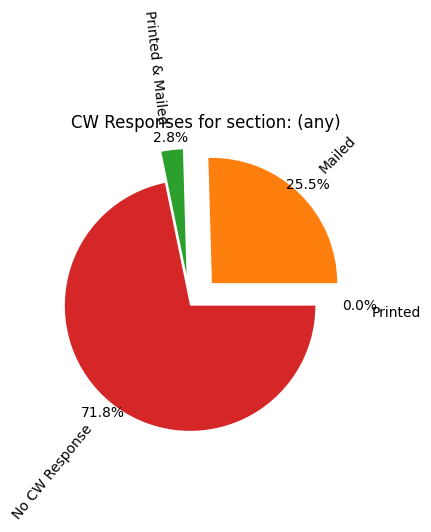

In [176]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [4, 4]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
def make_cw_pie(*, section='(any)', show_no_response=True, scale=1):
    labels = ['Printed', 'Mailed', 'Printed & Mailed']
    counts = get_counts(section=section)
    sizes = [counts.printed_only[0], counts.sent_only[0], counts.both[0]]
    explode = [0.05, 0.05, 0.05]  # Pull out the CW slices
    if show_no_response:
        labels.append('No CW Response')
        sizes.append(counts.neither[0])
        explode.append(0)
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, radius=0.2, explode=explode, labels=labels, autopct='%1.1f%%', startangle=0, rotatelabels=True, labeldistance=1.2, pctdistance=1.1)
    ax1.set_title(f'CW Responses for section: {section}')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    return plt

cw_pie = make_cw_pie()
cw_pie.show()

### Let's get fancy

Now, say we wanted to demonstrate that by section, in real time...

In [177]:
import ipywidgets

sections = %sql SELECT assigned_section FROM cw_responses GROUP BY 1;
sections = sections.DataFrame().assigned_section

section_dropdown = ipywidgets.Dropdown(
    options=['(any)', *sections],
    value='(any)',
    description='Assigned Section:',
    disabled=False,
)

show_no_response_checkbox = ipywidgets.Checkbox(True, description='Show "No CW Response"')

def observe_dropdown(*, section, show_no_response):
    plt.rcParams['figure.figsize'] = [4, 4]
    cw_pie = make_cw_pie(section=section, show_no_response=show_no_response)
    cw_pie.show()

ipywidgets.interact(observe_dropdown, section=section_dropdown, show_no_response=show_no_response_checkbox)
pass

interactive(children=(Dropdown(description='Assigned Section:', options=('(any)', 'ADM', 'APP', 'EOS', 'SPL', …

Or, maybe we just want to see all of the sections at once:

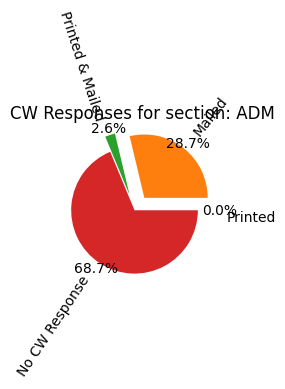

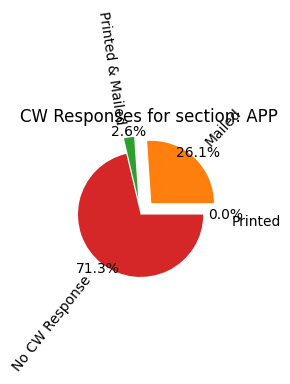

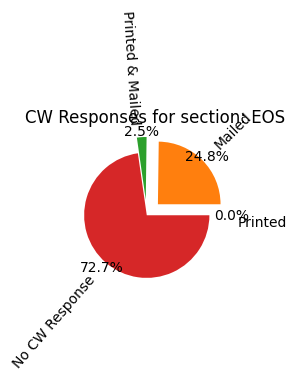

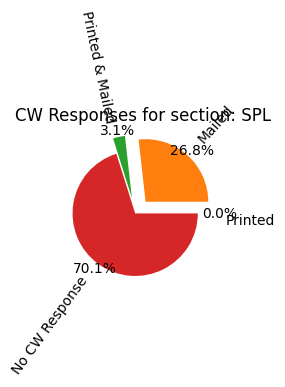

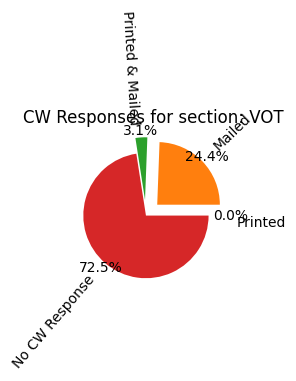

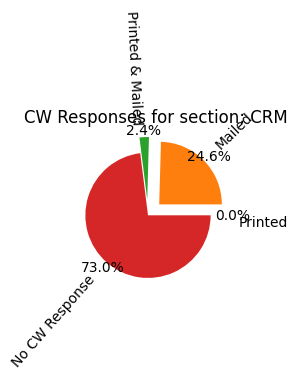

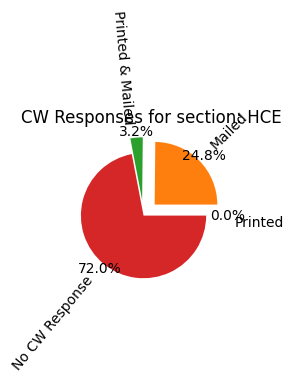

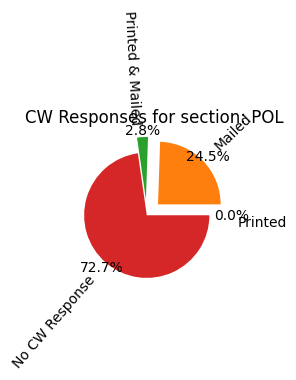

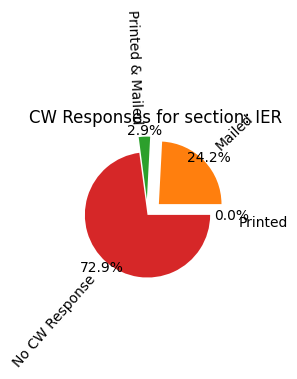

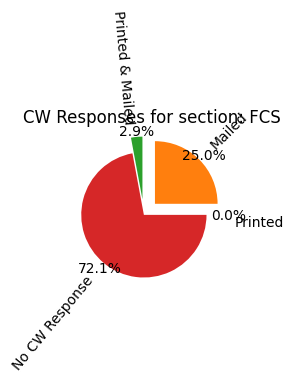

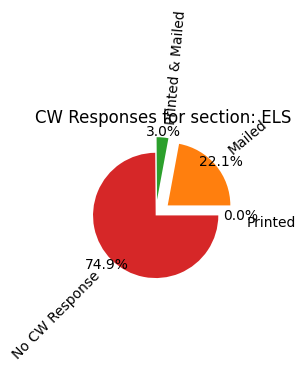

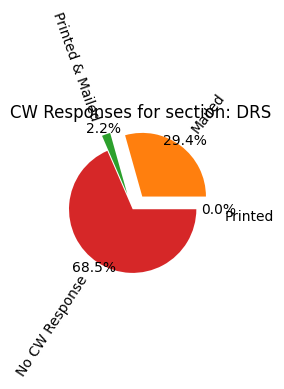

In [178]:
plt.rcParams['figure.figsize'] = [2, 2]
charts = [make_cw_pie(section=section) for section in sections]
for chart in charts:
    chart.show()